In [1]:
import numpy as np
#import mlflow
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.PINN.Block.Block_modular import *
from FEM_2d_elasticity import create_image_from_layout

%load_ext autoreload
%autoreload 2

#mlflow.autolog()

Using device: cuda


In [2]:
def find_deform(K, f):
    u = torch.linalg.solve(K, f)
    u_f = (u * f).sum(dim=(-2, -1))
    return u, u_f

def find_rho(layout, res=8):
    n = torch.where(layout[:,0]!=0, 1, 0).sum(dim=(-2, -1))
    M = (2*res*layout[:,0] + 2*(res-2*layout[:,0])*layout[:,1]) / (res*res)
    rho = M.sum(dim=(-2, -1)) / n
    return rho

def convert(input, layout):
    x, y = torch.meshgrid(torch.arange(1, 5), torch.arange(1, 5), indexing='ij')
    xy = torch.vstack([x.flatten(), y.flatten()]).to(device=dev)
    output_one_hot = F.gumbel_softmax(input, tau=1, hard=True, eps=1e-10, dim=1)
    output_x_num = (output_one_hot * xy[0].view(1,16,1,1)).sum(dim=1, keepdim=True)
    output_y_num = (output_one_hot * xy[1].view(1,16,1,1)).sum(dim=1, keepdim=True)
    output_xy = torch.cat([output_x_num, output_y_num], dim=1)
    output_clean = output_xy * layout[:, [0]].detach()
    return output_clean

## Academic examples

0: simply supported beam 6x6

2: simply supported beam 10x10

4: simply supported beam 20x20

1: L-beam 6x6

3: L-beam 10x10

5: L-beam 20x20

In [3]:
data = dataset_GAN('academic')
args = {'lr' : 0.1, 'epochs' : 100, 'dev' : dev, 'name' : 'NN_library/PINN/Block/Block_10x10_k3', 'train_mode' : 'stiffness', 'penalty' : 100.}
dis = Block_net(res=10, kernels=[1, 3], train_mode=args['train_mode'])
dis = load_network(dis, args['name'], args)
dis = dis.to(dev)
for p in dis.parameters():
    p.requires_grad_ = False
dis.eval()

Block_net(
  (conv_blocks): ModuleList(
    (0): Conv_block(
      (c11): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
      (c12): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv_block(
      (c11): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (c12): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (FNN_blocks): ModuleList(
    (0): Block_FNN(
      (convt): ConvTranspose2d(32, 1, kernel_size=(1, 36), stride=(1, 36), bias=False)
    )
    (1): Block_FNN(
      (convt): ConvTranspose2d(64, 1, kernel_size=(1, 528), stride=(1, 528), bias=False)
    )
  )
)

In [4]:
batch = 32
layout, support, force, zero_map, DBC, f = data.__getitem__(3)
layout = layout.repeat(batch, 1, 1, 1).to(dev)
f = f.to(dev).repeat(batch, 1, 1)
zero_map = zero_map.repeat(batch, 1, 1)
DBC = DBC.repeat(batch, 1, 1).to(dev)
K = dis(2*layout, zero_map, DBC, f)
_, u_max = find_deform(K+DBC, f)

In [5]:
x_0 = torch.zeros(batch, 16, layout.shape[-2], layout.shape[-1]).to(dev)
x_0.requires_grad_()
us = []
penalty = []
outputs = []
loss = []

In [6]:
optimizer = optim.Adam([x_0], lr = 0.1, maximize=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, threshold=1e-10, verbose=True, eps=1e-10)

In [10]:
args['penalty'] = 10.
for i in range(200):
    y = convert(x_0, layout)
    K = dis(y, zero_map, DBC, f)
    _, u = find_deform(K+DBC, f)
    rho = find_rho(y)
    p = args['penalty'] * torch.relu(rho-0.75)
    u_norm = u/u_max.detach()
    l = (u_norm + p).mean()
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    loss.append(l.detach().cpu())
    us.append(u_norm.detach().cpu())
    penalty.append(p.detach().cpu())
    outputs.append(y.detach().cpu())
    #print(i)
    #scheduler.step(l)   

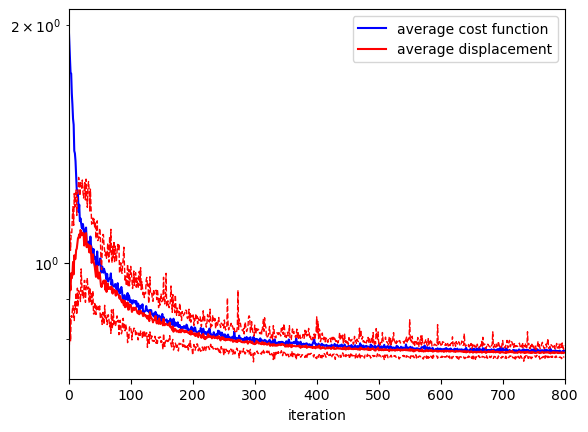

In [11]:
plt.plot(np.array(loss), c='b')
plt.plot(np.array(us).mean(axis=1), c='r')
plt.plot(np.array(us).min(axis=1), '--r', linewidth=1)
plt.plot(np.array(us).max(axis=1), '--r', linewidth=1)
#plt.plot(np.array(penalty).mean(axis=1))
plt.xlabel('iteration')
plt.xlim([0, len(loss)])
plt.legend(['average cost function', 'average displacement'])
plt.yscale('log')

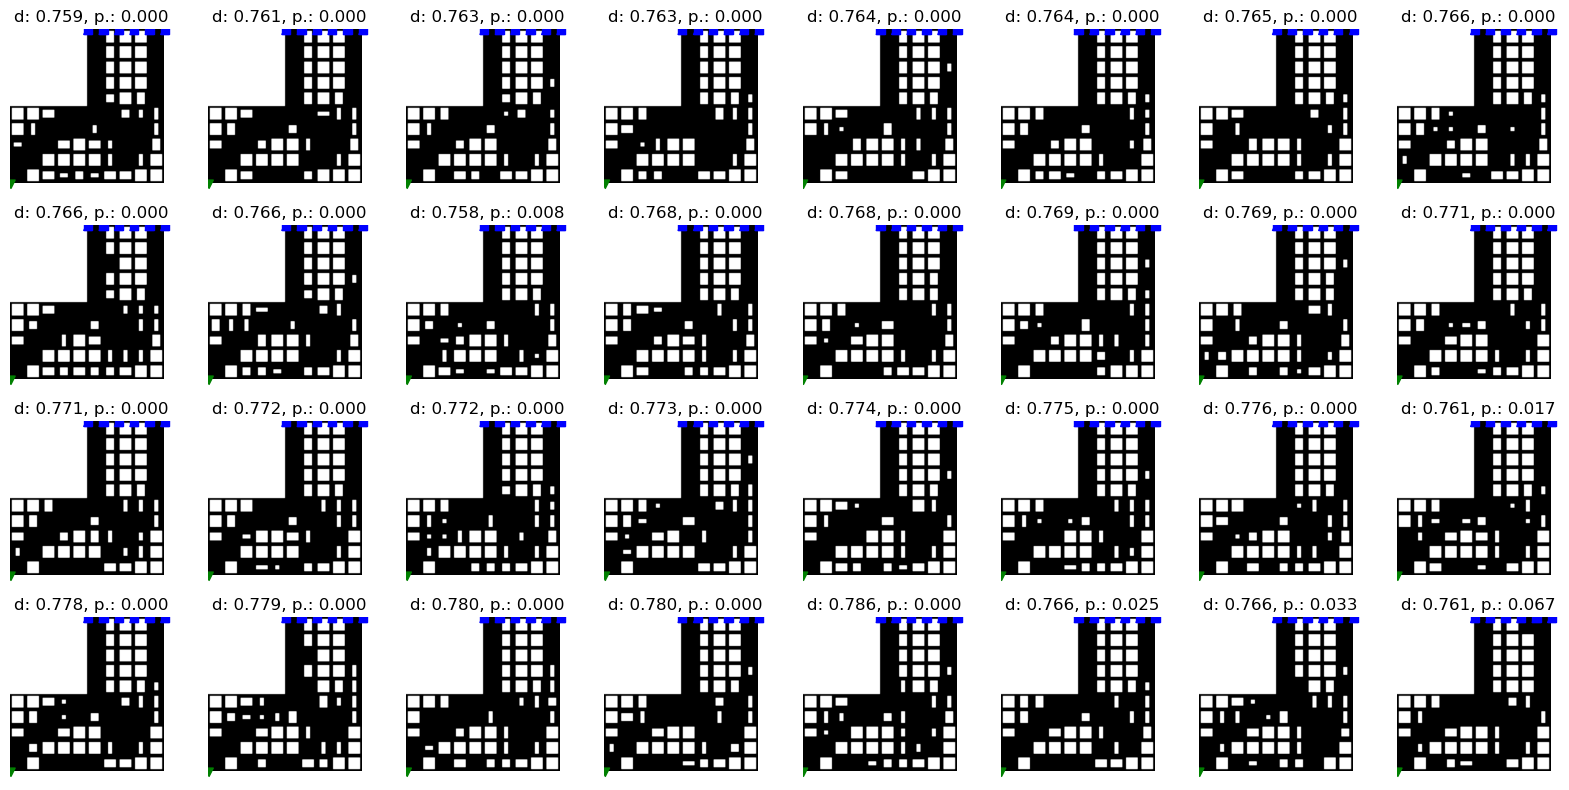

In [12]:
x_g, y_g = np.meshgrid(np.linspace(0, layout.shape[-2]*8, layout.shape[-2]+1), np.linspace(0, layout.shape[-1]*8, layout.shape[-1]+1))
fig, axs = plt.subplots(batch//8, 8, figsize=(2*8, 2*batch//8))
best_idx = torch.argsort(us[-1]+penalty[-1])
for j in range(batch):
    i = best_idx[j].item()
    img = create_image_from_layout(outputs[-1][i])
    axs.flat[j].imshow(img, cmap='Greys_r')
    axs.flat[j].scatter(x_g, y_g, c='b', marker='s', alpha=support[0].detach().cpu())
    axs.flat[j].scatter(x_g, y_g, c='b', marker='^', alpha=support[1].detach().cpu())
    axs.flat[j].scatter(x_g, y_g, c='g', marker='>', alpha=force[0].detach().cpu())
    axs.flat[j].scatter(x_g, y_g, c='g', marker='v', alpha=force[1].detach().cpu())
    axs.flat[j].set_title(f'd: {us[-1][i]:.3f}, p.: {penalty[-1][i]:.3f}')
    axs.flat[j].axis('off')
plt.tight_layout()

In [105]:
with open(f'x_0.pickle', 'wb') as handle:
    pickle.dump(x_0, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Run FEM

In [13]:
from FEM_2d_elasticity import *

coarse_grid = (layout.shape[-2], layout.shape[-1])
res = 8
coarse_x, coarse_y = np.meshgrid(np.arange(coarse_grid[0]+1), np.arange(coarse_grid[1]+1))
coarse_coordinates = np.vstack([coarse_x.flatten(), coarse_y.flatten()]).T
x, y = np.meshgrid(np.linspace(0, coarse_grid[0], coarse_grid[0]*res+1), np.linspace(0, coarse_grid[1], coarse_grid[1]*res+1))
x = x.flatten()
y = y.flatten()
glob_numbering = np.reshape(np.arange(len(x)), (coarse_grid[0]*res+1, coarse_grid[1]*res+1))
coarse_idx = glob_numbering[0::res,0::res].flatten()


# Create module stiffness matrices
K_module = {}
K_module[(0, 0)] = create_module_domain(1, 0, 0.3, 0, 0, res)
for i in range(1, res//2 + 1):   
    for j in range(1, res//2 + 1):
        K_module[(i, j)] = create_module_domain(1, 0, 0.3, i, j, res)

In [14]:
# L-console
#support_coarse = [2*coarse_grid[0]//2, 2*coarse_grid[0]//2+1, 2*coarse_grid[0], 2*coarse_grid[0]+1]
support_coarse = np.arange(2*coarse_grid[0]//2, 2*coarse_grid[0]+2)
support_hd = 2 * coarse_idx[support_coarse // 2] + (support_coarse % 2)
force_idx = np.vstack([2*coarse_idx, 2*coarse_idx+1]).T.flatten()
coarse_with_BC_idx = np.setdiff1d(force_idx, support_hd, assume_unique=False)
row_mask = np.isin(force_idx, coarse_with_BC_idx)
mask = np.outer(row_mask, row_mask)
F_glob = np.zeros((2*len(x), 1))
F_glob[force_idx] = f[0].detach().cpu()
f_idx = np.argwhere(f[0].detach().cpu().numpy())[0,0]

In [15]:
u_real = []
for n in range(batch):
    K_glob = assemble_global_stiffness(K_module, outputs[-1][n].detach().cpu().numpy().reshape(2, -1).T, coarse_grid, len(x), res)
    K_ff, F_f, dof = apply_BCs(K_glob, F_glob, support_hd)
    U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
    U_glob = np.zeros((2*len(x), 1))
    U_glob[dof] = U_ff
    u_real.append(U_glob[force_idx][f_idx])

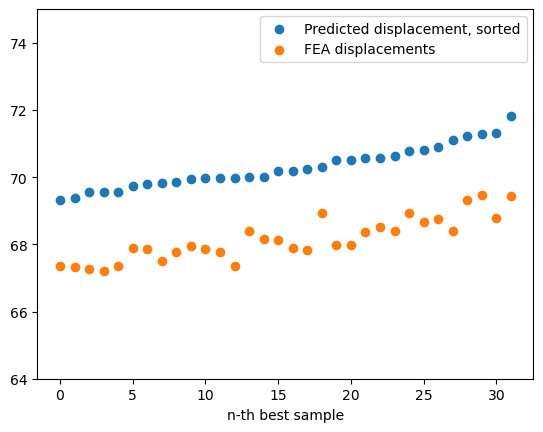

In [17]:
sorted = np.argsort(us[-1])
plt.scatter(np.arange(batch), us[-1][sorted]*u_max[0].item())
plt.scatter(np.arange(batch), np.array(u_real)[sorted])
plt.xlabel('n-th best sample')
plt.ylim([64, 75])
plt.legend(['Predicted displacement, sorted', 'FEA displacements'])